<a href="https://colab.research.google.com/github/DaeSeokSong/image-processing/blob/feature%2Fimage_segmentation-scar/Image_segmentation_Scar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set development enviroment

## Install

## Import

### Library

In [1]:
# Image processing
import cv2

from google.colab.patches import cv2_imshow
from google.colab import output

# ETC
import os
import time

### Google drive mount

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/Models/GAN_Scar
!ls -al

/content/gdrive/MyDrive/Models/GAN_Scar
total 12
drwx------ 2 root root 4096 Aug  9 13:27 Dataset
-rw------- 1 root root 7810 Aug 10 06:23 Image_segmentation-Scar.ipynb


# Image segmentation

## Global variable

In [31]:
MODEL_PATH = "/content/gdrive/MyDrive/Models/GAN_Scar"

TRAIN_SET_PATH = "/Dataset/train"
TEST_SET_PATH = "/Dataset/test"

IMAGES_PATH = '/images'
LABELS_PATH = '/labels'

NORM_INPUT_SIZE = 480

## Class

## Function

In [5]:
def imshow_waitkey_enter(image):
    cv2_imshow(image)

    time.sleep(0.5)
    input("Please press the Enter key to proceed\n")
    output.clear()

    pass

## Run

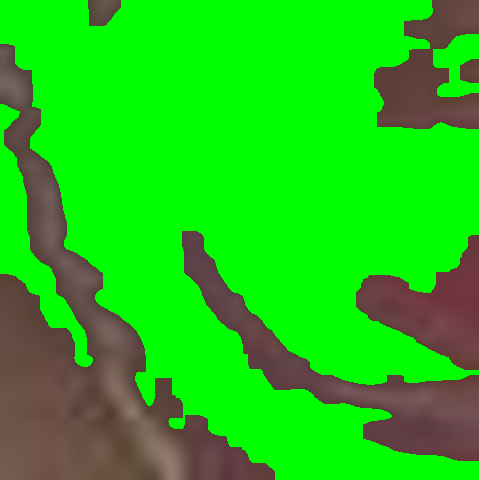

KeyboardInterrupt: ignored

In [43]:
# Set load image dir path
dirPath = MODEL_PATH + TRAIN_SET_PATH + IMAGES_PATH

# Load images
os.chdir(dirPath)
files = os.listdir(dirPath)

train_images = []
for f in files: 
    train_images.append(cv2.imread(f))

# Preprocess image
for image in train_images:
    # Get HSV image
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue_image, sat_image, val_image = cv2.split(hsv_image)

    # Substract background (black boundary)
    imageRegion, hierarchy = cv2.findContours(sat_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rect = cv2.boundingRect(imageRegion[0])
    image = image[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]

    # Resize image
    imageW = image.shape[0]
    imageH = image.shape[1]
    resizeRatioW = imageW / NORM_INPUT_SIZE
    resizeRatioH = imageH / NORM_INPUT_SIZE
    image = cv2.resize(image, 
                       (int(imageW / resizeRatioW), int(imageH / resizeRatioH)), 
                       interpolation=cv2.INTER_CUBIC
                       )
    imshow_waitkey_enter(image)

    # Get grayscale image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold
    _, ths_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)

    # Morphology
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    morph_image = cv2.morphologyEx(ths_image, cv2.MORPH_CLOSE, k)
    imshow_waitkey_enter(morph_image)

    # Select candidate of wound region
    contours, hierarchy = cv2.findContours(morph_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    for idx, contour in enumerate(contours):
        # Delete small region
        x, y, width, height = cv2.boundingRect(contour)
        if width < 20 or height < 20: continue

        box_image = cv2.drawContours(image, contours, idx, (0, 255, 0), -1)
    imshow_waitkey_enter(box_image)